# Ant colony CVRP problem realization

In [4]:
import random
import numpy as np
import re
import math
from scipy.spatial.distance import pdist, squareform
import os
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
def read_vrp(path):
    filepath = path
    file_list = []
    with open(filepath, 'r') as file:
        for line in file:
            file_list.append(line)

    num_consumers = int(re.sub("[^0-9]", "", file_list[3])) #amount of consumers
    Q = int(re.sub("[^0-9]", "", file_list[5])) #Capacity value

    opt_values = re.findall(r'\d+', file_list[1])
    opt_values = [int(value) for value in opt_values]

    num_trucks = opt_values[0] #optimal amount of trucks
    opt_value = opt_values[1]  #optimal distance

    start_index = file_list.index('NODE_COORD_SECTION \n') + 1
    end_index = file_list.index('DEMAND_SECTION \n')

    node_coord_section = file_list[start_index:end_index]    #NODE_COORD_SECTION in .vrp file
    demand_section = file_list[end_index+1:file_list.index('DEPOT_SECTION \n')]    #DEMAND_SECTION in .vrp file

    depot = file_list[file_list.index('DEPOT_SECTION \n')+1:file_list.index(' -1  \n')]
    depot = int(re.sub("[^0-9]", "", depot[0])) - 1

    consumers_index = []
    coords = []
    demand_list = []

    for i in range(len(node_coord_section)):
        coord = node_coord_section[i]
        coord = coord.split()

        consumers_index.append(int(coord[0])-1)
        coords.append((int(coord[1]), int(coord[2])))

        demand = demand_section[i]
        demands = demand.split()

        demand_list.append(int(demands[1]))

    return num_consumers, Q, num_trucks, opt_value, depot, consumers_index, coords, demand_list

In [3]:
def distance(coord1, coord2):
    return math.sqrt((coord2[0] - coord1[0]) ** 2 + (coord2[1] - coord1[1]) ** 2)

In [4]:
def form_matrix_distance(num_consumers, coords):
    matrix_distance = np.zeros((num_consumers, num_consumers)) #matrix with all distances between all consumers
    for i in range(num_consumers):
        for j in range(num_consumers):
            matrix_distance[i][j] = distance(coords[i], coords[j])


    matrix_distance_with_inf = np.where(matrix_distance == 0, np.inf, matrix_distance)
    eta = 1 / matrix_distance_with_inf

    min_dist = float('inf')

    for i in range(len(matrix_distance)):
        for j in range(len(matrix_distance)):
            if i != j and matrix_distance[i][j] != 0:
              min_dist = min(min_dist, matrix_distance[i][j])

    tau_0 = 1 / ((len(matrix_distance)+1)*min_dist)

    tau = np.zeros((len(matrix_distance), len(matrix_distance)))
    tau[:] = tau_0

    return matrix_distance, eta, tau, tau_0

In [5]:
def local_update_tau(current_consumer, tau, alpha, tau_0):
  #local udpate matrix with pheromone (after finding route for each ant)
    for i in range(1, len(current_consumer)):
        tau[current_consumer[i-1]][current_consumer[i]] = (1 - alpha) * tau[current_consumer[i-1]][current_consumer[i]] + alpha * tau_0
        tau[current_consumer[i]][current_consumer[i-1]] = (1 - alpha) * tau[current_consumer[i]][current_consumer[i-1]] + alpha * tau_0

In [6]:
def global_update_tau(dist_iter, sol_iter, tau, alpha):
  #global update matrix with pheromone (after finding routes for all ants)
    ind_min_dist=np.argmin(dist_iter)
    best_sol = sol_iter[ind_min_dist]

    for i in range(1, len(best_sol)):

        tau[best_sol[i-1]][best_sol[i]] = (1 - alpha) * tau[best_sol[i-1]][best_sol[i]] + (alpha / dist_iter[ind_min_dist])
        tau[best_sol[i]][best_sol[i-1]] = (1 - alpha) * tau[best_sol[i]][best_sol[i-1]] + (alpha / dist_iter[ind_min_dist])

In [7]:
def search_next_consumer(tau, eta, beta, current_consumer, free_consumers, consumers_index):

    q = random.random()
    Prob = np.multiply(tau, eta**beta)[current_consumer]

    for i in consumers_index:
        if i not in free_consumers:
            Prob[i] = 0

    if np.sum(Prob) == 0:
        next_consumer = np.random.choice(free_consumers)
    elif q <= q0:
        next_consumer = np.argmax(Prob)
    else:
        Prob /= np.sum(Prob)
        next_consumer = np.random.choice(consumers_index, p=Prob)


    return next_consumer

In [8]:
def search_best_route(num_iter,depot, matrix_distance, eta, tau, tau_0, num_trucks, consumers_index):

    dist_best = 0
    sol_best = []
    trucks_lim=[]
    #dist_iter_array=[]

    for it in range(num_iter):

        visited_consumers = [depot]
        free_consumers = consumers_index[:depot] + consumers_index[depot+1:]

        dist_iter = []  #distance for all ants using during one iteation
        sol_iter = []   #overall solution
        num_veh = num_trucks
        ant = 0

        while True:

            if ant == num_veh:
                break

            current_ant_consumer = [depot] #current route of ant
            current_load = 0
            dist_one = 0 #distance of one art

            while free_consumers:

                next_consumer = search_next_consumer(tau, eta, beta, current_ant_consumer[-1] , free_consumers, consumers_index)
                next_load = demand_list[next_consumer]

                if current_load + next_load > Q:
                    break

                current_load += next_load
                dist_one += matrix_distance[current_ant_consumer[-1]][next_consumer]
                current_ant_consumer.append(next_consumer)
                visited_consumers.append(next_consumer)
                free_consumers.remove(next_consumer)

            dist_one += matrix_distance[current_ant_consumer[-1]][depot] #sent ant to depot after capacity limit or all consumers ends
            current_ant_consumer.append(depot)
            local_update_tau(current_ant_consumer, tau, alpha, tau_0)
            dist_iter.append(dist_one)
            sol_iter.append(current_ant_consumer)
            if free_consumers and ant == num_veh - 1:
                num_veh += 1
            ant += 1

        global_update_tau(dist_iter, sol_iter, tau, alpha)

        if dist_best == 0:
            dist_best = np.sum(dist_iter)
            sol_best = sol_iter
        elif np.sum(dist_iter) < dist_best:
            dist_best = np.sum(dist_iter)
            sol_best = sol_iter
        trucks_lim.append(num_veh-num_trucks)

        #Second method for stop iterations
        #dist_iter_array.append(np.sum(dist_iter))
        #if len(dist_iter_array)>5:
        #  dist_iter_array=dist_iter_array[-5:]

        #if (len(dist_iter_array)==5) and (np.absolute(np.max(dist_iter_array)-min(dist_iter_array))<20):
        #  break

    return dist_best, sol_best, np.mean(trucks_lim)


In [9]:
def sort_key(filename):
    parts = filename.split('-')
    n_value = int(parts[1][1:])  # Извлекаем число после 'n'
    k_value = int(parts[2][1:].split('.')[0])  # Извлекаем число после 'k'
    return (n_value, k_value)

In [ ]:
def find_optimal_parameters(path_set,filenames_sort):

    global num_consumers, Q, num_trucks, opt_value, depot, demand_list, coords, consumers_index
    error = []

    for name in filenames_sort:

        path_name = '/'.join([path_set, name])

        num_consumers, Q, num_trucks, opt_value, depot, consumers_index, coords, demand_list = read_vrp(path_name)
        matrix_distance, eta, tau, tau_0 = form_matrix_distance(num_consumers, coords)
        dist_best, sol_best, mean_gap_trucks = search_best_route(num_iter,depot, matrix_distance, eta, tau, tau_0, num_trucks, consumers_index)
        relative_error = ((dist_best - opt_value) / opt_value) * 100
        error.append(relative_error)

    mean_error = np.mean(error)

    return mean_error

# Search for parameters on set A

In [ ]:
A = [] #list with all file names

path_A = '/kaggle/input/vrp-set-a-1'

for _, _, files in os.walk(path_A):
    for filename in files:
        A.append(filename)

vrp_list = [s for s in A if ".sol" not in s]
filenames_sort = sorted(vrp_list, key=sort_key)

In [ ]:
random.seed(2024)

num_iter = 1000

q0_set = [0.5, 0.6, 0.7, 0.8, 0.9]
beta_set = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
alpha_set = [0.1, 0.3, 0.5, 0.7, 0.9]

In [ ]:
parameters_set_A = pd.DataFrame({'q0':[], 'beta':[], 'alpha':[], 'error':[]})

for i in range(len(q0_set)):
    for j in range(len(beta_set)):
        for k in range(len(alpha_set)):
            q0 = q0_set[i]
            beta = beta_set[j]
            alpha = alpha_set[k]
            error_mean = find_optimal_parameters(path_A,filenames_sort)
            parameters_set_A.loc[len(parameters_set_A.index)] = [q0, beta, alpha, error_mean]

In [ ]:
pd.set_option('display.max_columns', None)
print(parameters_set_A)

In [ ]:
s=parameters_set_A.sort_values('error')
print(s.iloc[0:1])

In [ ]:
parameters_set_A.to_csv('/kaggle/working/parameters_setA.csv',index=False)

# Solutions for set A

In [ ]:
#q0=float(s.loc[0,'q0'])
#beta=float(s.loc[0,'beta'])
#alpha=float(s.loc[0,'alpha'])

q0, beta, alpha = 0.7,5,0.9

random.seed(2024)
num_iter = 1000

array_solutions = []
coords_for_plot = []

data_set_A = pd.DataFrame({'name':[], 'num_consumers':[], 'error':[], 'time':[], 'dist':[], 'optimal':[], 'gap_trucks':[]})

for i in range(len(filenames_sort)):
    name = filenames_sort[i]
    path_name = '/'.join([path_A, name])

    num_consumers, Q, num_trucks, opt_value, depot, consumers_index, coords, demand_list = read_vrp(path_name)
    matrix_distance, eta, tau, tau_0 = form_matrix_distance(num_consumers, coords)

    start_time = time.time()
    dist_best, sol_best, mean_gap_trucks = search_best_route(num_iter,depot, matrix_distance, eta, tau, tau_0, num_trucks, consumers_index)
    end_time = time.time()
    error = ((dist_best - opt_value) / opt_value) * 100

    data_set_A.loc[len(data_set_A.index)] = [name, num_consumers, error, end_time - start_time, dist_best, opt_value, mean_gap_trucks]

    coords_for_plot.append(coords)
    array_solutions.append(sol_best)

    print(name, ' ', error, ' ', end_time-start_time,' ', mean_gap_trucks)
    #plt.plot(dist_iter_array)


# Plot best and worst results (topology), statistics (relative error and time) with best parameters

Topology of the best and worst finding solution

32
33


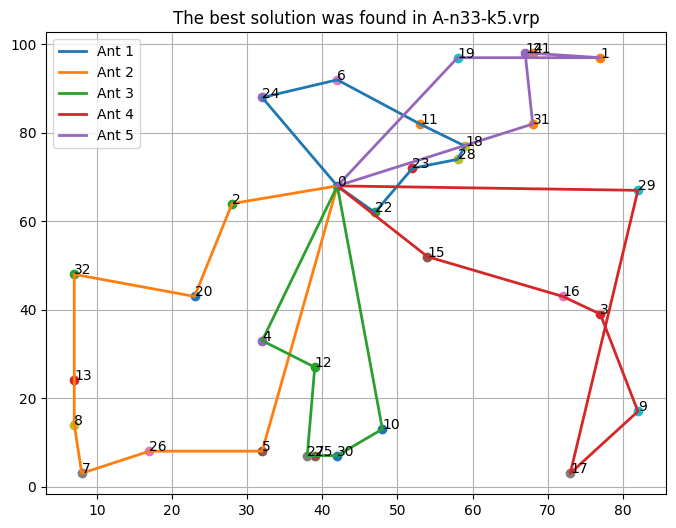

In [12]:
index_plot = data_set_A['error'].idxmin()
best_sol = array_solutions[index_plot]
coords = coords_for_plot[index_plot]
name_file = data_set_A['name'][index_plot]


sum = 0
for i in best_sol:
  sum += len(i)

sum = sum - 2 * len(best_sol)
print(sum)
print(len(coords))


plt.figure(figsize=(8, 6))

for i in range(len(coords)):
    x = coords[i][0]
    y = coords[i][1]
    plt.scatter(x, y)
    plt.text(x, y, f"{consumers_index[i]}")

for i, route in enumerate(best_sol):
    x = [coords[consumer][0] for consumer in route]
    y = [coords[consumer][1] for consumer in route]
    plt.plot(x, y, linestyle='-', linewidth=2, label=f'Ant {i+1}')
    plt.legend()

plt.title('The best solution was found in '+f'{name_file}')
plt.grid()
plt.show()

64
65


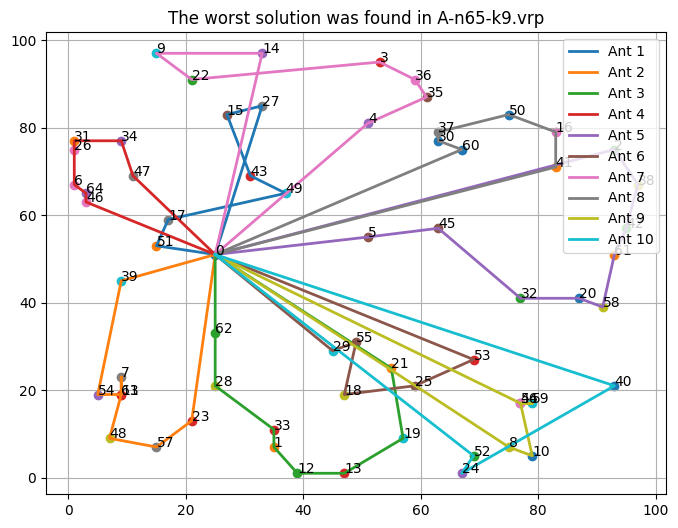

In [13]:
index_plot = data_set_A['error'].idxmax()
best_sol = array_solutions[index_plot]
coords = coords_for_plot[index_plot]
name_file = data_set_A['name'][index_plot]


sum = 0
for i in best_sol:
  sum += len(i)

sum = sum - 2 * len(best_sol)
print(sum)
print(len(coords))


plt.figure(figsize=(8, 6))

for i in range(len(coords)):
    x = coords[i][0]
    y = coords[i][1]
    plt.scatter(x, y)
    plt.text(x, y, f"{consumers_index[i]}")

for i, route in enumerate(best_sol):
    x = [coords[consumer][0] for consumer in route]
    y = [coords[consumer][1] for consumer in route]
    plt.plot(x, y, linestyle='-', linewidth=2, label=f'Ant {i+1}')
    plt.legend()

plt.title('The worst solution was found in '+f'{name_file}')
plt.grid()
plt.show()

Dependence accuracy and calculation time vs number of consumers

In [16]:
np.mean(data_set_A['error'])

11.128414292273309

In [17]:
np.mean(data_set_A['time'])

7.848491580397995

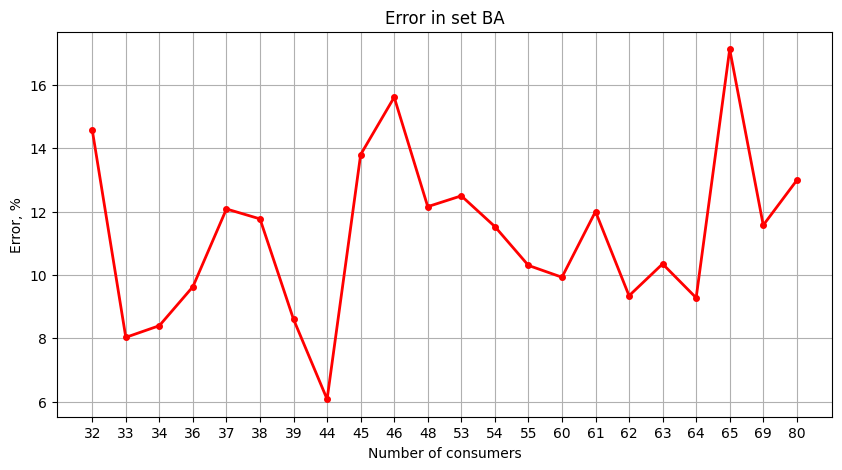

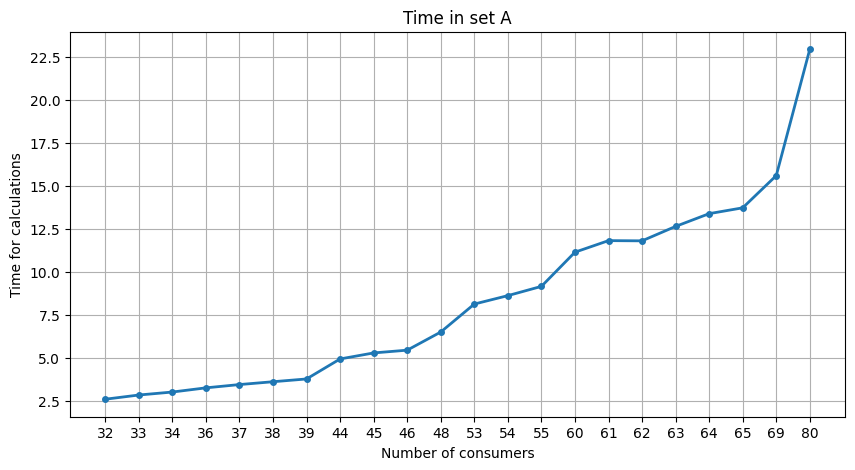

In [14]:
grouped_set_A = data_set_A.groupby('num_consumers').agg({'error':'mean', 'time':'mean'}).reset_index()
x_pos = range(len(grouped_set_A['num_consumers']))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_pos, grouped_set_A['error'], '.-', linewidth = 2, markeredgewidth = 2, color='red')
plt.xticks(x_pos, grouped_set_A['num_consumers'])
plt.xlabel('Number of consumers')
plt.ylabel('Error, %')
plt.title('Error in set BA')
ax.grid()
plt.show()


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_pos, grouped_set_A['time'], '.-', linewidth = 2, markeredgewidth = 2)
plt.xticks(x_pos, grouped_set_A['num_consumers'])
plt.xlabel('Number of consumers')
plt.ylabel('Time for calculations')
plt.title('Time in set A')
ax.grid()
plt.show()

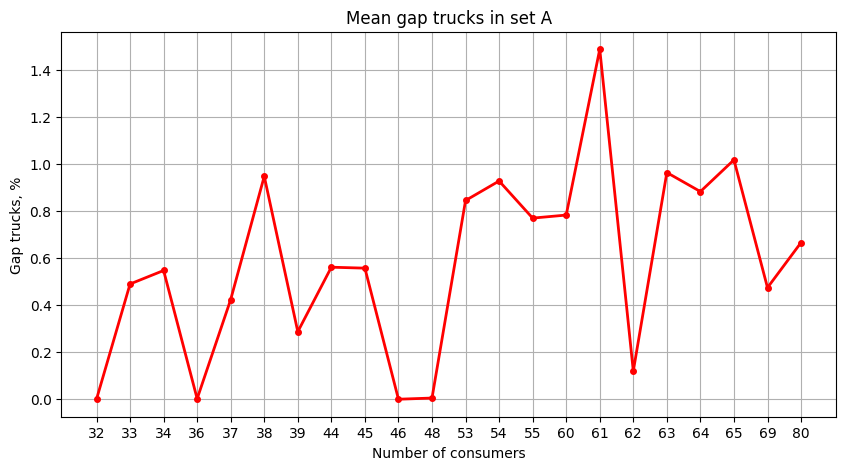

In [15]:
grouped_set_A = data_set_A.groupby('num_consumers').agg({'gap_trucks':'mean'}).reset_index()
x_pos = range(len(grouped_set_A['num_consumers']))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_pos, grouped_set_A['gap_trucks'], '.-', linewidth = 2, markeredgewidth = 2, color='red')
plt.xticks(x_pos, grouped_set_A['num_consumers'])
plt.xlabel('Number of consumers')
plt.ylabel('Gap trucks, %')
plt.title('Mean gap trucks in set A')
ax.grid()
plt.show()